In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import time

%matplotlib inline

In [2]:
# Load dataset
url = "https://archive.ics.uci.edu/static/public/967/phiusiil+phishing+url+dataset.zip"
df = pd.read_csv(url, encoding="utf-8")
df = df.drop("FILENAME", axis=1)
print(f"Dataset shape: {df.shape}")
print(f"Label distribution: {df['label'].value_counts(normalize=True).round(3)}")
df.head()

Dataset shape: (235795, 55)
Label distribution: label
1    0.572
0    0.428
Name: proportion, dtype: float64


,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,0.061933,...,0,0,1,34,20,28,119,0,124,1
1,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,0.050207,...,0,0,1,50,9,8,39,0,217,1
2,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,0.064129,...,0,0,1,10,2,7,42,2,5,1
3,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,0.057606,...,1,1,1,3,27,15,22,1,31,1
4,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,0.059441,...,1,0,1,244,15,34,72,1,85,1


# Feature Engineering

In [3]:
# Extract numeric features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('label')
X_numeric = df[numeric_cols].copy()

# TLD feature engineering
tld_phishing = df.groupby('TLD')['label'].agg(['count', 'mean'])
tld_phishing = tld_phishing.sort_values(by=['mean'], ascending=False)

tld_counts = df['TLD'].value_counts()
X_numeric['tld_frequency'] = df['TLD'].map(tld_counts.to_dict())
X_numeric['tld_frequency'] = pd.cut(X_numeric['tld_frequency'], 
                                   bins=[0, 10, 100, 1000, np.inf], 
                                   labels=[0, 1, 2, 3]).astype(int)

high_phish_tlds = tld_phishing[tld_phishing['mean'] > 0.9].index.tolist()
X_numeric['is_high_phish_tld'] = df['TLD'].isin(high_phish_tlds).astype(int)

# Domain feature engineering
domain_counts = df['Domain'].value_counts()
X_numeric['domain_frequency'] = df['Domain'].map(domain_counts.to_dict())
X_numeric['domain_frequency'] = pd.cut(X_numeric['domain_frequency'], 
                                      bins=[0, 1, 5, 50, np.inf], 
                                      labels=[0, 1, 2, 3])
X_numeric['domain_frequency'] = X_numeric['domain_frequency'].astype(int)

# Title feature engineering
title_counts = df['Title'].value_counts()
X_numeric['title_frequency'] = df['Title'].map(title_counts.to_dict())
X_numeric['title_frequency'] = pd.cut(X_numeric['title_frequency'], 
                                     bins=[0, 1, 5, np.inf], 
                                     labels=[0, 1, 2]).astype(int)
X_numeric['title_length'] = df['Title'].str.len()

# Handle remaining categorical columns
remaining_categorical = df.select_dtypes(include=['object']).columns.tolist()
remaining_categorical = [col for col in remaining_categorical if col not in ['URL', 'Domain', 'TLD', 'Title', 'label']]

if len(remaining_categorical) > 0:
    le = LabelEncoder()
    for col in remaining_categorical:
        X_numeric[col] = le.fit_transform(df[col].astype(str))

X = X_numeric
y = df['label']

print(f"Features: {X.shape[1]}, Samples: {X.shape[0]:,}")
print(f"Added features: {len([col for col in X.columns if col.startswith(('tld_', 'domain_', 'title_', 'is_'))])}")

Features: 55, Samples: 235,795
Added features: 5


# Data Splitting and Scaling

In [4]:
# Train/validation/test split (60/20/20)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"Train: {len(X_train):,} | Val: {len(X_val):,} | Test: {len(X_test):,}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Train: 141,477 | Val: 47,159 | Test: 47,159


In [5]:
def evaluate_model(name, model, X_train, X_val, X_test, y_train, y_val, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test)
    
    try:
        val_proba = model.predict_proba(X_val)[:, 1]
        test_proba = model.predict_proba(X_test)[:, 1]
        val_auc = roc_auc_score(y_val, val_proba)
        test_auc = roc_auc_score(y_test, test_proba)
    except:
        val_auc = test_auc = None
    
    val_acc = accuracy_score(y_val, val_pred)
    test_acc = accuracy_score(y_test, test_pred)
    val_f1 = f1_score(y_val, val_pred)
    test_f1 = f1_score(y_test, test_pred)
    val_precision = precision_score(y_val, val_pred)
    test_precision = precision_score(y_test, test_pred)
    val_recall = recall_score(y_val, val_pred)
    test_recall = recall_score(y_test, test_pred)
    
    tn, fp, fn, tp = confusion_matrix(y_test, test_pred).ravel()
    specificity = tn / (tn + fp)
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    print(f"{name}:")
    print(f"  Val: Acc={val_acc:.4f}, F1={val_f1:.4f}, Prec={val_precision:.4f}, Rec={val_recall:.4f}" + 
          (f", AUC={val_auc:.4f}" if val_auc else ""))
    print(f"  Test: Acc={test_acc:.4f}, F1={test_f1:.4f}, Prec={test_precision:.4f}, Rec={test_recall:.4f}" + 
          (f", AUC={test_auc:.4f}" if test_auc else ""))
    print(f"  Additional: Specificity={specificity:.4f}, NPV={npv:.4f}, Time={training_time:.3f}s")
    
    return {
        'val_acc': val_acc, 'test_acc': test_acc,
        'val_f1': val_f1, 'test_f1': test_f1,
        'val_precision': val_precision, 'test_precision': test_precision,
        'val_recall': val_recall, 'test_recall': test_recall,
        'val_auc': val_auc, 'test_auc': test_auc,
        'specificity': specificity, 'npv': npv,
        'training_time': training_time
    }

results = {}

# Decision Tree

In [6]:
dt_model = DecisionTreeClassifier(max_depth=15, min_samples_split=50, min_samples_leaf=20, random_state=42)
results['Decision Tree'] = evaluate_model('Decision Tree', dt_model, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)

Decision Tree:
  Val: Acc=0.9998, F1=0.9998, Prec=0.9996, Rec=1.0000, AUC=1.0000
  Test: Acc=0.9997, F1=0.9998, Prec=0.9996, Rec=1.0000, AUC=1.0000
  Additional: Specificity=0.9994, NPV=1.0000, Time=0.238s


# Random Forest

In [7]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=50, min_samples_leaf=20, random_state=42, n_jobs=-1)
results['Random Forest'] = evaluate_model('Random Forest', rf_model, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)

Random Forest:
  Val: Acc=1.0000, F1=1.0000, Prec=1.0000, Rec=1.0000, AUC=1.0000
  Test: Acc=1.0000, F1=1.0000, Prec=0.9999, Rec=1.0000, AUC=1.0000
  Additional: Specificity=0.9999, NPV=1.0000, Time=0.737s


# K-Nearest Neighbors with Hyperparameter Tuning

In [8]:
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}
knn_base = KNeighborsClassifier(weights='distance', algorithm='auto', n_jobs=-1)

grid_search = GridSearchCV(knn_base, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_k = grid_search.best_params_['n_neighbors']
print(f"Best K: {best_k}, CV Score: {grid_search.best_score_:.4f}")

knn_model = KNeighborsClassifier(n_neighbors=best_k, weights='distance', algorithm='auto', n_jobs=-1)
results['KNN'] = evaluate_model('KNN', knn_model, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)

Best K: 3, CV Score: 0.9985
KNN:
  Val: Acc=0.9988, F1=0.9990, Prec=0.9982, Rec=0.9997, AUC=0.9993
  Test: Acc=0.9986, F1=0.9988, Prec=0.9981, Rec=0.9994, AUC=0.9992
  Additional: Specificity=0.9974, NPV=0.9993, Time=0.011s


# Results Summary

In [9]:
results_df = pd.DataFrame(results).T.sort_values('val_f1', ascending=False)

print("=" * 80)
for model, row in results_df.iterrows():
    print(f"\n{model}:")
    print(f"  Performance: Acc={row['test_acc']:.4f}, F1={row['test_f1']:.4f}, Precision={row['test_precision']:.4f}")
    print(f"  Reliability: Recall={row['test_recall']:.4f}, Specificity={row['specificity']:.4f}, NPV={row['npv']:.4f}")
    auc_str = f", AUC={row['test_auc']:.4f}" if row['test_auc'] is not None else ""
    print(f"  Speed: Time={row['training_time']:.3f}s{auc_str}")


Random Forest:
  Performance: Acc=1.0000, F1=1.0000, Precision=0.9999
  Reliability: Recall=1.0000, Specificity=0.9999, NPV=1.0000
  Speed: Time=0.737s, AUC=1.0000

Decision Tree:
  Performance: Acc=0.9997, F1=0.9998, Precision=0.9996
  Reliability: Recall=1.0000, Specificity=0.9994, NPV=1.0000
  Speed: Time=0.238s, AUC=1.0000

KNN:
  Performance: Acc=0.9986, F1=0.9988, Precision=0.9981
  Reliability: Recall=0.9994, Specificity=0.9974, NPV=0.9993
  Speed: Time=0.011s, AUC=0.9992


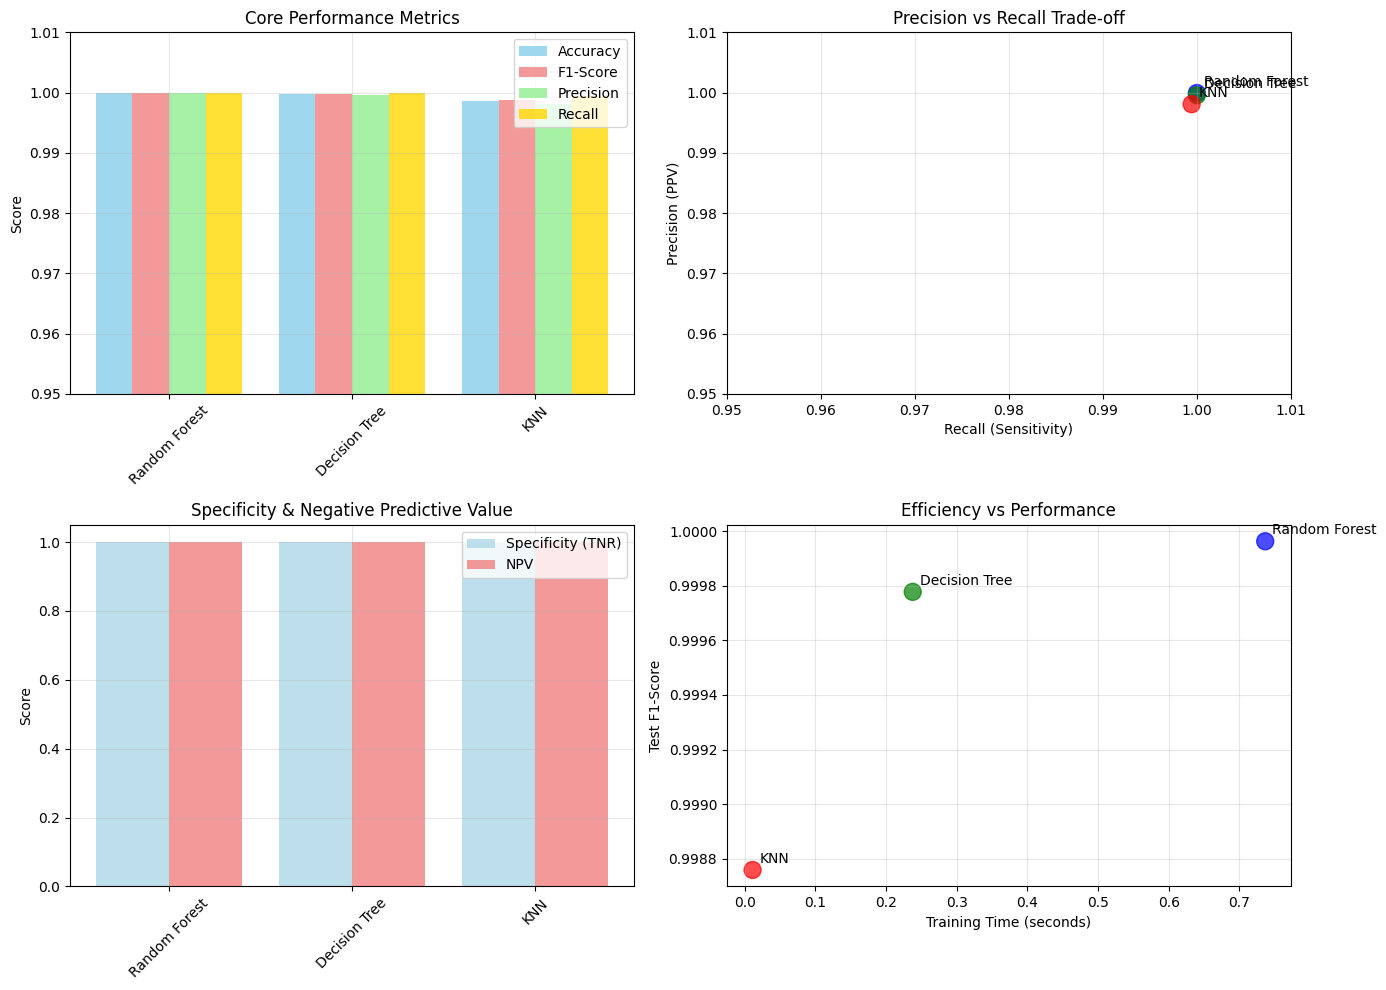

In [10]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

models = results_df.index
x = np.arange(len(models))

metrics = ['test_acc', 'test_f1', 'test_precision', 'test_recall']
metric_labels = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

for i, (metric, label, color) in enumerate(zip(metrics, metric_labels, colors)):
    ax1.bar(x + i*0.2 - 0.3, results_df[metric], width=0.2, label=label, color=color, alpha=0.8)

ax1.set_title('Core Performance Metrics')
ax1.set_ylabel('Score')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0.95, 1.01)

ax2.scatter(results_df['test_recall'], results_df['test_precision'], s=150, alpha=0.7, c=['blue', 'green', 'red'])
for model in models:
    ax2.annotate(model, (results_df.loc[model, 'test_recall'], results_df.loc[model, 'test_precision']), 
                xytext=(5, 5), textcoords='offset points')
ax2.set_title('Precision vs Recall Trade-off')
ax2.set_xlabel('Recall (Sensitivity)')
ax2.set_ylabel('Precision (PPV)')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0.95, 1.01)
ax2.set_ylim(0.95, 1.01)

x_pos = np.arange(len(models))
ax3.bar(x_pos - 0.2, results_df['specificity'], width=0.4, label='Specificity (TNR)', alpha=0.8, color='lightblue')
ax3.bar(x_pos + 0.2, results_df['npv'], width=0.4, label='NPV', alpha=0.8, color='lightcoral')
ax3.set_title('Specificity & Negative Predictive Value')
ax3.set_ylabel('Score')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(models, rotation=45)
ax3.legend()
ax3.grid(True, alpha=0.3)

ax4.scatter(results_df['training_time'], results_df['test_f1'], s=150, alpha=0.7, c=['blue', 'green', 'red'])
for model in models:
    ax4.annotate(model, (results_df.loc[model, 'training_time'], results_df.loc[model, 'test_f1']), 
                xytext=(5, 5), textcoords='offset points')
ax4.set_title('Efficiency vs Performance')
ax4.set_xlabel('Training Time (seconds)')
ax4.set_ylabel('Test F1-Score')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()